In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 55kB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import resnet50
import math
import numpy as np
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import random

# **construct model structure**


trying to recover RefineNet, it's a simpler version


*   not using dilated convolution
*   in multi-resoluition fusion module, the input sizs is almost the same(in the original paper, the resolution of the inputs are not the same)





In [3]:
def ResidualConvUnit(inputs, features=256, kernel_size=3):
  net = ReLU()(inputs)
  net = Conv2D(features, kernel_size, padding='same', activation='relu')(net)
  net = Conv2D(features, kernel_size, padding='same')(net)
  net = Add()([net, inputs])
  return net

In [4]:
def ChainedResidualPooling(inputs, features=256):
  net_relu = ReLU()(inputs)
  net = MaxPool2D([5, 5], 1, padding='same')(net_relu)
  net = Conv2D(features, 3, padding='same')(net)
  net_sum_1 = Add()([net, net_relu])

  net = MaxPool2D([5, 5], 1, padding='same')(net_relu)
  net = Conv2D(features, 3, padding='same')(net)
  net_sum_2 = Add()([net, net_sum_1])

  return net_sum_2

In [5]:
def unpool(inputs):
  h, w = inputs.shape[1], inputs.shape[2]
  return tf.image.resize(inputs, size=[h*2, w*2], method='bilinear')

In [6]:
def MultiResolutionFusion(high_inputs=None, low_inputs=None, features=256):
  if not high_inputs:
    rcu_low_1 = low_inputs[0]
    rcu_low_2 = low_inputs[1]
    rcu_low_1 = Conv2D(features,3, padding='same')(rcu_low_1)
    rcu_low_2 = Conv2D(features,3, padding='same')(rcu_low_2)

    return Add()([rcu_low_1, rcu_low_2])
  else:
    rcu_low_1 = low_inputs[0]
    rcu_low_2 = low_inputs[1]
    rcu_low_1 = Conv2D(features,3, padding='same')(rcu_low_1)
    rcu_low_2 = Conv2D(features,3, padding='same')(rcu_low_2)

    rcu_low = Add()([rcu_low_1, rcu_low_2])

    rcu_high_1 = high_inputs[0]
    rcu_high_2 = high_inputs[1]
    rcu_high_1 = Conv2D(features,3, padding='same')(rcu_high_1)
    rcu_high_2 = Conv2D(features,3, padding='same')(rcu_high_2)

    rcu_high = Add()([rcu_high_1, rcu_high_2])
    return Add()([rcu_low, rcu_high])

4-cascaded refinenet

In [7]:
def RefineBlock(high_inputs=None,low_inputs=None):

    if high_inputs is None: # block 4
        rcu_low_1= ResidualConvUnit(low_inputs, features=256)
        rcu_low_2 = ResidualConvUnit(low_inputs, features=256)
        rcu_low = [rcu_low_1, rcu_low_2]

        fuse = MultiResolutionFusion(high_inputs=None, low_inputs=rcu_low, features=256)
        fuse_pooling = ChainedResidualPooling(fuse, features=256)
        output = ResidualConvUnit(fuse_pooling, features=256)
        return output
    else:
        rcu_low_1 = ResidualConvUnit(low_inputs, features=256)
        rcu_low_2 = ResidualConvUnit(low_inputs, features=256)
        rcu_low = [rcu_low_1, rcu_low_2]

        rcu_high_1 = ResidualConvUnit(high_inputs, features=256)
        rcu_high_2 = ResidualConvUnit(high_inputs, features=256)
        rcu_high = [rcu_high_1, rcu_high_2]

        fuse = MultiResolutionFusion(rcu_high, rcu_low,features=256)
        fuse_pooling = ChainedResidualPooling(fuse, features=256)
        output = ResidualConvUnit(fuse_pooling, features=256)
        return output

In [8]:
def getmodel(nClasses, input_height, input_width):
  images = Input(shape=(input_height, input_width, 3))
  resnet_layer = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=images)
  basemodel = tf.keras.Model(resnet_layer.input, resnet_layer.output)
  basemodel.trainable = False
  f = [basemodel.get_layer('conv2_block3_out').output,
       basemodel.get_layer('conv3_block4_out').output,
       basemodel.get_layer('conv4_block6_out').output,
       basemodel.get_layer('conv5_block3_out').output]
  g = [None, None, None, None]
  h = [None, None, None, None]

  for i in range(4):
    h[i] = Conv2D(256, 1)(f[3-i])
  
  g[0] = RefineBlock(None, h[0])
  g[0] = Lambda(unpool)(g[0])

  g[1] = RefineBlock(g[0], h[1])
  g[1] = Lambda(unpool)(g[1])
  
  g[2] = RefineBlock(g[1], h[2])
  g[2] = Lambda(unpool)(g[2])
  
  g[3] = RefineBlock(g[2], h[3])
  
  F_score = Conv2DTranspose(nClasses, (4, 4), strides=(4, 4), padding='valid', activation='relu')(g[3])
  F_score = Reshape((-1, nClasses))(F_score)
  F_score = Activation('softmax')(F_score)
  
  model = tf.keras.Model(inputs = images, outputs = F_score)
  return model

In [ ]:
# model = getmodel(9, 320, 320)
# model.summary(line_length=200)

94773248/94765736 [==============================] - 1s 0us/step


# **load batches**

In [9]:
def getImageArr(im):

    img = im.astype(np.float32)

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    return img

one-hot encode the annotation

In [10]:
def getSegmentationArr(seg, nClasses, input_height, input_width):

    seg_labels = np.zeros((input_height, input_width, nClasses))

    for c in range(nClasses):
        seg_labels[:, :, c] = (seg == c).astype(int)

    seg_labels = np.reshape(seg_labels, (-1, nClasses))
    return seg_labels

In [11]:
def imageSegmentationGenerator(images_path, segs_path, batch_size, n_classes, input_height, input_width):

    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = sorted(glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg"))

    segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

    zipped = itertools.cycle(zip(images, segmentations))

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = zipped.__next__()
            im = cv2.imread(im, 1)
            seg = cv2.imread(seg, 0)

            assert im.shape[:2] == seg.shape[:2]
            assert im.shape[0] >= input_height and im.shape[1] >= input_width

            # cut the image to the shape of (h, w ,c)
            xx = random.randint(0, im.shape[0] - input_height)
            yy = random.randint(0, im.shape[1] - input_width)

            im = im[xx:xx + input_height, yy:yy + input_width]
            seg = seg[xx:xx + input_height, yy:yy + input_width]

            X.append(getImageArr(im))
            Y.append(getSegmentationArr( seg, n_classes, input_height, input_width))

        yield np.array(X), np.array(Y)

# **train preprocess: define hyperparameters and create model**

set parameters

In [12]:
train_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_train/"
train_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_train/"
train_batch_size = 16
n_classes = 11

epochs = 500

input_height = 320
input_width = 320


val_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_test/"
val_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_test/"
val_batch_size = 8

In [13]:
model = getmodel(n_classes, input_height, input_width)

94773248/94765736 [==============================] - 3s 0us/step


In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adadelta",
    metrics=['acc'])

In [15]:
G = imageSegmentationGenerator(train_images_path, train_segs_path, train_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)
G_test = imageSegmentationGenerator(val_images_path, val_segs_path, val_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

# **first training 500 epochs**

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
23/23 [==============================] - 726s 32s/step - loss: 12.2639 - acc: 0.1647 - val_loss: 11.8876 - val_acc: 0.2042
Epoch 2/500
23/23 [==============================] - 67s 3s/step - loss: 10.4272 - acc: 0.2503 - val_loss: 9.8483 - val_acc: 0.2560
Epoch 3/500
23/23 [==============================] - 14s 615ms/step - loss: 8.3510 - acc: 0.3284 - val_loss: 8.5454 - val_acc: 0.3130
Epoch 4/500
23/23 [==============================] - 14s 612ms/step - loss: 7.7249 - acc: 0.3628 - val_loss: 8.3724 - val_acc: 0.3185
Epoch 5/500
23/23 [==============================] - 14s 611ms/step - loss: 7.2501 - acc: 0.3775 - val_loss: 7.5093 - val_acc: 0.3400
Epoch 6/500
23/23 [==============================] - 14s 611ms/step - loss: 6.6429 - acc: 0.3935 - val_loss: 6.8236 - val_acc: 0.3602
Epoch 7/500
23/23 [==============================] - 14s 609ms/step - loss: 6.1185 - acc: 0.4100 - val_loss: 6.5600 - val

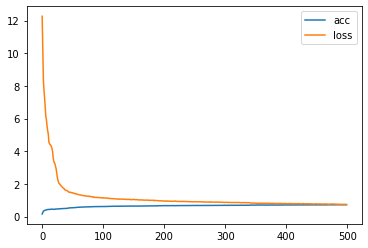

In [16]:
history = model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model.save_weights('/content/drive/MyDrive/refinenet_final.h5')


acc = history.history['acc']
loss = history.history['loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

In [ ]:
# didn't delete because want to keep the previous training process

Epoch 1/200
46/46 [==============================] - 14s 311ms/step - loss: 0.6018 - acc: 0.7761 - val_loss: 1.0735 - val_acc: 0.6653
Epoch 2/200
46/46 [==============================] - 13s 286ms/step - loss: 0.6130 - acc: 0.7733 - val_loss: 1.1174 - val_acc: 0.6456
Epoch 3/200
46/46 [==============================] - 13s 282ms/step - loss: 0.6071 - acc: 0.7745 - val_loss: 1.0370 - val_acc: 0.6574
Epoch 4/200
46/46 [==============================] - 13s 285ms/step - loss: 0.6058 - acc: 0.7747 - val_loss: 1.0355 - val_acc: 0.6743
Epoch 5/200
46/46 [==============================] - 13s 282ms/step - loss: 0.5939 - acc: 0.7798 - val_loss: 1.0911 - val_acc: 0.6549
Epoch 6/200
46/46 [==============================] - 13s 283ms/step - loss: 0.6011 - acc: 0.7782 - val_loss: 1.0549 - val_acc: 0.6479
Epoch 7/200
46/46 [==============================] - 13s 280ms/step - loss: 0.6086 - acc: 0.7753 - val_loss: 0.9820 - val_acc: 0.6746
Epoch 8/200
46/46 [==============================] - 13s 281ms

# **12.4 training, loaded weights, using adadelta, has no improvmant at all: main reason is those small objects**

In [ ]:
model.load_weights('/content/drive/MyDrive/refinenet.h5')

In [ ]:
model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model.save_weights('/content/drive/MyDrive/refinenet_12_4.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
12/12 [==============================] - 617s 51s/step - loss: 0.5545 - acc: 0.7904 - val_loss: 1.1363 - val_acc: 0.6525
Epoch 2/200
12/12 [==============================] - 59s 5s/step - loss: 0.5553 - acc: 0.7912 - val_loss: 1.0379 - val_acc: 0.6684
Epoch 3/200
12/12 [==============================] - 14s 1s/step - loss: 0.5533 - acc: 0.7913 - val_loss: 0.9761 - val_acc: 0.6765
Epoch 4/200
12/12 [==============================] - 14s 1s/step - loss: 0.5564 - acc: 0.7912 - val_loss: 1.0734 - val_acc: 0.6624
Epoch 5/200
12/12 [==============================] - 14s 1s/step - loss: 0.5551 - acc: 0.7909 - val_loss: 1.0443 - val_acc: 0.6686
Epoch 6/200
12/12 [==============================] - 14s 1s/step - loss: 0.5623 - acc: 0.7865 - val_loss: 0.9791 - val_acc: 0.6775
Epoch 7/200
12/12 [==============================] - 14s 1s/step - loss: 0.5493 - acc: 0.7923 - val_loss: 1.0226 - val_acc: 0.6851
Epoch

In [ ]:

model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model.save_weights('/content/drive/MyDrive/refinenet_12_4_500epochs.h5')

Epoch 1/300
12/12 [==============================] - 14s 1s/step - loss: 0.5337 - acc: 0.7975 - val_loss: 1.0067 - val_acc: 0.6715
Epoch 2/300
12/12 [==============================] - 14s 1s/step - loss: 0.5476 - acc: 0.7933 - val_loss: 1.0532 - val_acc: 0.6700
Epoch 3/300
12/12 [==============================] - 14s 1s/step - loss: 0.5455 - acc: 0.7916 - val_loss: 1.1281 - val_acc: 0.6612
Epoch 4/300
12/12 [==============================] - 14s 1s/step - loss: 0.5466 - acc: 0.7959 - val_loss: 0.9630 - val_acc: 0.6916
Epoch 5/300
12/12 [==============================] - 14s 1s/step - loss: 0.5436 - acc: 0.7948 - val_loss: 0.9949 - val_acc: 0.6708
Epoch 6/300
12/12 [==============================] - 14s 1s/step - loss: 0.5493 - acc: 0.7919 - val_loss: 1.0544 - val_acc: 0.6711
Epoch 7/300
12/12 [==============================] - 14s 1s/step - loss: 0.5440 - acc: 0.7947 - val_loss: 1.1123 - val_acc: 0.6550
Epoch 8/300
12/12 [==============================] - 14s 1s/step - loss: 0.5406 - a

# **using adadelta, it will be oscillating around the local minima, so change to adam, try some more epochs: results are bad: loss does not drop at all**

Epoch 1/500
23/23 [==============================] - 15s 660ms/step - loss: 12.8297 - acc: 0.1730 - val_loss: 13.4319 - val_acc: 0.1522
Epoch 2/500
23/23 [==============================] - 14s 613ms/step - loss: 12.7357 - acc: 0.1775 - val_loss: 13.0162 - val_acc: 0.1776
Epoch 3/500
23/23 [==============================] - 14s 612ms/step - loss: 12.5257 - acc: 0.1936 - val_loss: 12.9722 - val_acc: 0.1799
Epoch 4/500
23/23 [==============================] - 14s 614ms/step - loss: 12.5363 - acc: 0.1934 - val_loss: 13.0754 - val_acc: 0.1745
Epoch 5/500
23/23 [==============================] - 14s 612ms/step - loss: 12.5229 - acc: 0.1936 - val_loss: 13.0709 - val_acc: 0.1752
Epoch 6/500
23/23 [==============================] - 14s 613ms/step - loss: 12.5425 - acc: 0.1932 - val_loss: 12.9370 - val_acc: 0.1819
Epoch 7/500
23/23 [==============================] - 14s 615ms/step - loss: 12.5595 - acc: 0.1930 - val_loss: 12.9748 - val_acc: 0.1789
Epoch 8/500
23/23 [=============================

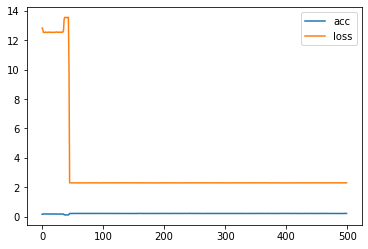

In [18]:
model_adam = getmodel(n_classes, input_height, input_width)
model_adam.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['acc'])
G = imageSegmentationGenerator(train_images_path, train_segs_path, train_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)
G_test = imageSegmentationGenerator(val_images_path, val_segs_path, val_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)
history = model_adam.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)
model_adam.save_weights('/content/drive/MyDrive/refinenet_final_adam.h5')


acc = history.history['acc']
loss = history.history['loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

# **demo predict**

In [ ]:
input_height = 320
input_width = 320
model = getmodel(n_classes, input_height, input_width)
model.load_weights('/content/drive/MyDrive/refinenet_12_4_500epochs.h5')
images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_test/"
segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_test/"

In [ ]:
colors = [ (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]


In [ ]:
def label2color(colors, n_classes, seg):
    """
    inputs: 
            colors: a map from class_label to a specific color
            n_classes:
            seg: predict result: (b, h * w, n_classes)
    output:
        seg_color: (b, h * w, 3)
    """
    seg_color = np.zeros((seg.shape[0], seg.shape[1], 3))
    for c in range(n_classes):
        seg_color[:, :, 0] += ((seg == c) * (colors[c][0])).astype('uint8')
        seg_color[:, :, 1] += ((seg == c) * (colors[c][1])).astype('uint8')
        seg_color[:, :, 2] += ((seg == c) * (colors[c][2])).astype('uint8')
    seg_color = seg_color.astype(np.uint8)
    return seg_color

In [ ]:
def getcenteroffset(shape, input_height, input_width):
    short_edge = min(shape[:2])
    xx = int((shape[0] - short_edge) / 2)
    yy = int((shape[1] - short_edge) / 2)
    return xx, yy

In [ ]:
images = sorted(glob.glob( images_path + "*.jpg") + glob.glob( images_path + "*.png") + glob.glob( images_path + "*.jpeg"))
segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

In [ ]:
from google.colab.patches import cv2_imshow

# **previous training result**

In [ ]:
for i, (imgName, segName) in enumerate(zip(images, segmentations)):

    print("%d/%d %s" % (i + 1, len(images), imgName))

    im = cv2.imread(imgName, 1)
    xx, yy = getcenteroffset(im.shape, input_height, input_width)
    im = im[xx:xx + input_height, yy:yy + input_width, :]

    seg = cv2.imread(segName, 0)
    seg = seg[xx:xx + input_height, yy:yy + input_width]

    pr = model.predict(np.expand_dims(getImageArr(im), 0))[0]
    pr = pr.reshape((input_height, input_width, n_classes)).argmax(axis=2)

    cv2_imshow(im)
    cv2_imshow(label2color(colors, n_classes, pr))
    cv2_imshow(label2color(colors, n_classes, seg))

    cv2.waitKey()

Output hidden; open in https://colab.research.google.com to view.